# ПРОЕКТ RDS-5 "Car Prediction"
### КОМАНДА "WRECKING CREW", DST-10
**Авдуевский Александр, Гололобов Андрей, Семенов Иван**

## 0. ВВЕДЕНИЕ

**Дано:** датасет с "анкетными данными" некогда проданных/выставленных на продажу в московском регионе автомобилей BWM с пробегом.

**Задача:** восстановить их цены (отстуствуют в датасете) на основе внешних данных при помощи методов машинного обучения.

*Поскольку процесс работы над проектом был сильно распараллелен, данный нотутбук включает в себя только его основной вектор и не отражает его последовательную хронологию.*

Первичный анализ тестового датасета и дотсупных источников данных, показал, что информация в датасете основана скорее всего на данных сайта auto.ru на конец 2019 года. Соответственно основным источником данных был выбран сайт auto.ru.

В процессе парсинга упор делался на данные, аналогичные представленным в датасете, плюс была взята информация, на основе которой могли быть теоретически созданы групповые признаки, переносимые в тестовый сет (например, средний рейтинг модели) или в какой-то степени восстановимые на основе текстового описания (например, является ли продавец дилером и каким). Также были взяты поля, могущие служить "контролем" для других полей.

Поскольку парсинг задача достаточно автономная, по соображениям компактности, соответствующий код вынесен в отдельный файл, находящийся в этом же репозитории. Сам парсинг из данного ноутбука не вызывается, используется сам результат его работы.

## 1. Загрузка и первичный анализ

In [5]:
# Импортируем библиотеки, сначала те, что используются в BaseLine
# Если будем применять другие алгоритмы МО, добавим их
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import rds_5_preproc as preproc
import json
RANDOM_SEED = 42

C:\Users\79067\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              3837 non-null   object 
 1   brand                 3837 non-null   object 
 2   color                 3837 non-null   object 
 3   fuelType              3837 non-null   object 
 4   modelDate             3837 non-null   float64
 5   name                  3837 non-null   object 
 6   numberOfDoors         3837 non-null   float64
 7   productionDate        3837 non-null   float64
 8   vehicleConfiguration  3837 non-null   object 
 9   vehicleTransmission   3837 non-null   object 
 10  engineDisplacement    3837 non-null   object 
 11  enginePower           3837 non-null   object 
 12  description           3837 non-null   object 
 13  mileage               3837 non-null   float64
 14  Комплектация          3837 non-null   object 
 15  Привод               

In [7]:
test.columns=['body_type', 'mark', 'color', 'fuel_type', 'model_date', 'name',
       'number_of_doors', 'production_date', 'configuration',
       'transmission', 'engine_displacement', 'engine_power',
       'description', 'mileage', 'package', 'drive', 'steer', 'condition',
       'owners', 'pts', 'customs', 'ownership', 'id']
pd.set_option('display.max_columns', 25)
test.head()

,body_type,mark,color,fuel_type,model_date,name,number_of_doors,production_date,configuration,transmission,engine_displacement,engine_power,description,mileage,package,drive,steer,condition,owners,pts,customs,ownership,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,0
1,седан,BMW,белый,дизель,2018.0,318d 2.0d AT (150 л.с.),4.0,2019.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,150 N12,Автомобиль из демонстрационного парка по спец ...,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,1
2,седан,BMW,синий,бензин,2009.0,550i xDrive 4.4 AT (407 л.с.) 4WD,4.0,2012.0,SEDAN AUTOMATIC 4.4,автоматическая,4.4 LTR,407 N12,Машина собиралась под заказ! \n\n,120000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,7 лет и 2 месяца,2
3,внедорожник 5 дв.,BMW,белый,дизель,2014.0,30d 3.0d AT (249 л.с.) 4WD,5.0,2015.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,249 N12,АВТОМОБИЛЬ В БЕЗУПРЕЧНОМ ВНЕШНЕМ И ТЕХНИЧЕСКОМ...,111466.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,NaN,3
4,внедорожник 5 дв.,BMW,синий,дизель,2014.0,M50d 3.0d AT (381 л.с.) 4WD,5.0,2019.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,381 N12,Автомобиль не имеет собственников ( физ. лиц) ...,11891.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,4


In [8]:
train =pd.read_csv('auto_ru_all.csv', index_col=0)
# https://drive.google.com/file/d/1SQn4gi2Ip6hoO8Uaa0ahGepq5SHV8rpK/view?usp=sharing
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90794 entries, 0 to 90793
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body_type            90792 non-null  object 
 1   body_type_add        90792 non-null  object 
 2   color_hex            90794 non-null  object 
 3   condition            90794 non-null  float64
 4   customs              90794 non-null  float64
 5   description          86984 non-null  object 
 6   drive                90791 non-null  object 
 7   engine_displacement  90791 non-null  float64
 8   engine_power         90791 non-null  float64
 9   fuel_type            90791 non-null  object 
 10  loc_add              90794 non-null  object 
 11  location             90794 non-null  object 
 12  mark                 90794 non-null  object 
 13  mileage              90794 non-null  float64
 14  model_date           90792 non-null  float64
 15  model_date_add       81769 non-null 

Поскольку тестовый сет содержит только BMW, было очевидно, что полезность информации по остальным маркам неочевидна с т.з. собственно спортивного результата, при том, что в рамках более общей задачи, эта информация является важной.
Изначально были скачаны предложения по всем маркам сразу, но с учетом высказанных соображений датасет был облегчен путем удаления мало представленных и откровенно экзотических марок, а также отечественного автопрома.

In [9]:
core_brands = ['AUDI', 'BMW', 'CHEVROLET', 'CITROEN', 'DAEWOO', 'FORD', 'HONDA',
       'HYUNDAI', 'KIA', 'LAND_ROVER', 'LEXUS', 'MAZDA', 'MERCEDES',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'RENAULT', 'SKODA',
       'TOYOTA', 'VOLKSWAGEN', 'VOLVO']
train = train[train.mark.isin(core_brands)]

Довольно быстро стало ясно, что растаможка и неаварийное состояние являются константами в обоих сетах, и нет необходимости к ним обращаться. Также быстро отпала необходимость в технических полях. 

In [10]:
print(sorted(train.model_date.unique()))

[1904.0, 1908.0, 1927.0, 1932.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1948.0, 1949.0, 1950.0, 1951.0, 1953.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, nan, 2020.0]


На ранних этапах также было ясно, что начиная с определенного возраста машины начинают котироваться по совершенно другим принциипам, и в дело вступают критерии, не формализуемые по используемой сетке. Учитывая, что в тестовый сет в глубь времен идет всего до 1981 года, было принято решение ограничить диапазон снизу, как минимум 1975 годом.


In [11]:
train = train[train.production_date > 1975]


Разумеется, нет никакого смысла использовать записи, в которых не указана цена. 

In [12]:
train.dropna(subset=['price'], inplace=True)

И нам не нужны дубликаты. Явных дубликатов не так уж много, если смотреть относительно общей массы. Надо полагать, auto.ru довольно хорошо борется со спаммерами.

In [13]:
print(train[[x for x in train.columns if x != 'description']].duplicated().sum())
train.drop_duplicates(subset=[x for x in train.columns if x != 'description'], inplace=True)

552


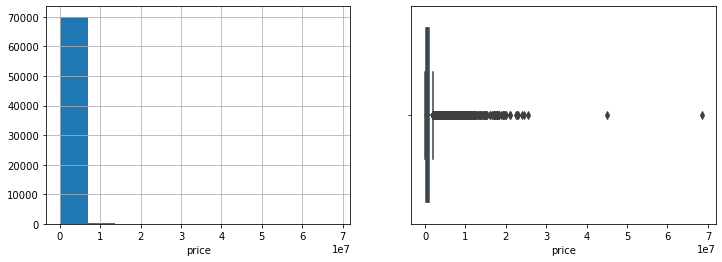

In [14]:

import rds_5_preproc as preproc
preproc.hist_and_box(train.price)



Распределение цен крайне несимметрично, но если логарифмировать, то все будет ОК.

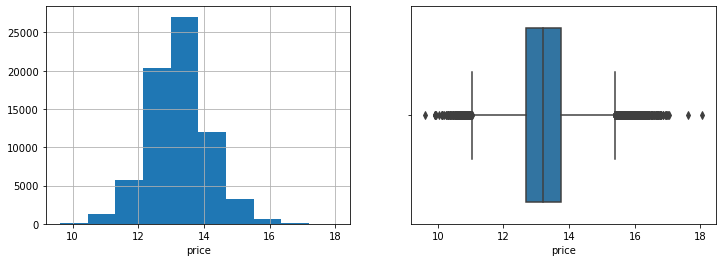

In [15]:
preproc.hist_and_box(np.log(train.price))

In [16]:
#Поскольку есть еще вопрос точности вычислений, логарфмируем с масштабированием, чтобы не терять "хвосты"
train['price_log'] = np.log(train.price)*10000

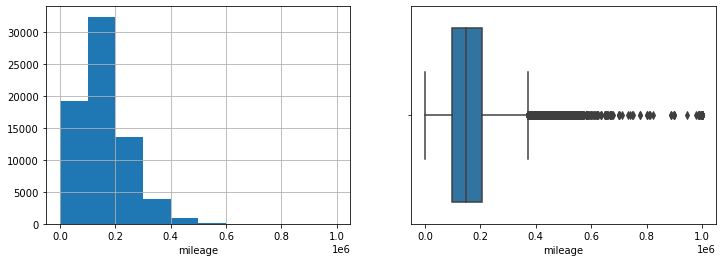

In [17]:
preproc.hist_and_box(train.mileage)

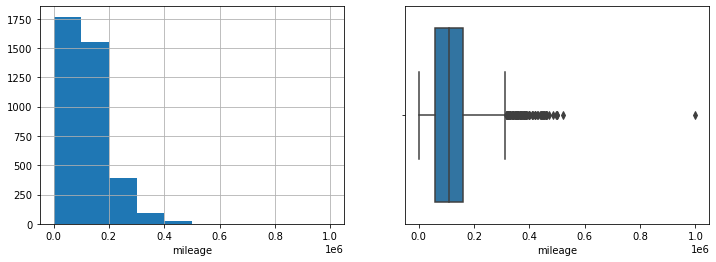

In [18]:
preproc.hist_and_box(test.mileage)

Машины с экстремальным пробегом тоже могут давать какой угодно разнос в ценообразовании, хотя бы в силу разного соотношения "родных" и замененных частей (и разного происхождения последних). Имеет смысл хотя бы поджать диапазон до 600 тыс. км.


In [19]:
train = train[train.mileage<600000]

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70282 entries, 193 to 88030
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body_type            70281 non-null  object 
 1   body_type_add        70281 non-null  object 
 2   color_hex            70282 non-null  object 
 3   condition            70282 non-null  float64
 4   customs              70282 non-null  float64
 5   description          67304 non-null  object 
 6   drive                70281 non-null  object 
 7   engine_displacement  70281 non-null  float64
 8   engine_power         70281 non-null  float64
 9   fuel_type            70281 non-null  object 
 10  loc_add              70282 non-null  object 
 11  location             70282 non-null  object 
 12  mark                 70282 non-null  object 
 13  mileage              70282 non-null  float64
 14  model_date           70281 non-null  float64
 15  model_date_add       64597 non-nul

Несмотря на то, что оба датасета происходят из auto.ru, ряд параметров в них присутствует в разных вариантах. Это обусловлено методом парсинга, который получает данные в виде записей БД, а в тестовом сете они содержатся в виде, в котором их интерпретирует фронтенд. Поскольку в трейне различных значений априори больше, мы будем "приводить к общему знаменателю" тест.

In [21]:



test['color_hex']= test.color.map({'чёрный':'040001',
                                       'белый':'FAFBFB',
                                       'синий':'0000CC',
                                       'серый':'97948F',
                                       'коричневый':'200204',
                                       'серебристый':'CACECB',
                                       'красный':'EE1D19',
                                       'бежевый':'C49648',
                                       'голубой':'22A0F8',
                                       'зелёный':'007F00',
                                       'оранжевый':'FF8649',
                                       'золотистый':'DEA522',
                                       'пурпурный':'660099',
                                       'фиолетовый':'4A2197',
                                       'жёлтый':'FFD600',
                                      })

test.body_type = test.body_type.map({'внедорожник 5 дв.':'ALLROAD_5_DOORS',
                                   'седан':'SEDAN',
                                   'купе':'COUPE',
                                   'хэтчбек 5 дв.':'HATCHBACK_5_DOORS',
                                   'лифтбек':'LIFTBACK',
                                   'универсал 5 дв.':'WAGON_5_DOORS',
                                   'хэтчбек 3 дв.':'HATCHBACK_3_DOORS',
                                   'кабриолет':'CABRIO',
                                   'родстер':'ROADSTER',
                                   'компактвэн':'COMPACTVAN',
                                   'седан 2 дв.':'SEDAN_2_DOORS',
                                  })
    
test.fuel_type = test.fuel_type.map({'бензин':'GASOLINE',
                                   'дизель':'DIESEL',
                                   'гибрид':'HYBRID',
                                   'электро':'ELECTRO',
                                  })
test.transmission = test.transmission.map({'автоматическая':'AUTOMATIC',
                                              'механическая':'MECHANICAL',
                                              'роботизированная':'ROBOT',
                                               })
test.drive = test.drive.map({'полный':'ALL_WHEEL_DRIVE',
                                   'задний':'REAR_DRIVE',
                                   'передний':'FORWARD_CONTROL'
                                  })


test.pts = test.pts.map({'Оригинал':'ORIGINAL','Дубликат':'DUPLICATE'})
    
def engine_displacement(x):
    vol = x.split(' ')[0]
    try:
        return int(float(vol)*1000)
    except:
        return 0
    
test.engine_displacement = test.engine_displacement.apply(engine_displacement)
    
def engine_power(x):
    return int (x.split(' ')[0])
      
    
test.engine_power = test.engine_power.apply(engine_power)    


test.owners = test.owners.apply(lambda x: x[0]).astype(int)

Проделав эту операцию, можно двигаться дальше по признакам, работая уже с обоими сетами.

Ценная, но далеко не всегда наличествующая информация - срок владения машиной последним владельцем. Надо отметить, что признак этот взаимосвязан с возрастом самого автомобиля, т.е. с какого-то момента не важно 4 или 5 лет. Сайт auto.ru делит срок на три категории - меньше года, от года до трех и больше трех. Вполне разумным будет следовать этому же принципу.

In [22]:
from datetime import datetime as dt


def calc_ownership(date):
    try:
        ym = date.split(',')
        year = int(ym[0].split(': ')[1])
        mnth = int(ym[1].split(': ')[1][:-1])
        year_now = dt.now().year
        month_now = dt.now().month
        
        dy = year_now-year
        dm = month_now - mnth
        
        if dy == 0:
            return 'LE_1'
        if 12 * dy + dm > 36:
            return 'GR_3'
        return 'LE_3'
    except:
        return 'NA'
    return 'NA'
    
train['ownership'] = train.purchase_date.apply(calc_ownership)



In [23]:
def test_ownership(x):
    
    try:
        y_str = re.findall(r'\d+ лет|\d+ год', x)[0].split(' ')[0]
        
        years=int(y_str)
    except:
        years = 0

    try:
        m_str = re.findall(r'\d+ мес', x)[0].split(' ')[0]
        
        months = int(m_str)
    except:
        months = 0
        
    if years+months == 0:
        return 'NA'
    if years == 0:
        return 'LE_1'
    if years * 12 + months < 36:
       
        return 'LE_3'
    return 'GR_3'

test.ownership = test.ownership.apply(test_ownership)

В отношении возраста модели и конкретного экземпляра, логично оперировать не датами, а именно возрастом. Поскольку есть разница между датировками теста и трейна, могла иметь смысл коррекция возраста у теста. Но практика показала, что единообразие дает более точный результат, особенно с учетом того, что все равно приходится делать коррекцию предсказаний с поправкой на курс рубля/инфляцию.


In [24]:
for i, df in enumerate((train, test)):
    df['age'] = 2020 - df.production_date
    df['model_age'] = 2020 - df.model_date 


Теперь займемся  комплектацией в обоих сетах.
Будем использовать русские термины, потому что так проще осмысленно работать с признаками.

Сначала обработаем трейн, потом сгенерируем для начала простые бинарные признаки по каждому элементу комплектации. Словарь фич комплектации большой, поэтому вынесен в отдельный модуль для утилит.

In [25]:
def parse_package(x):
    try:
        y= x.replace('\'','"').replace('True','"True"')
        feats = list(json.loads(y).keys())
        return [preproc.feat_dict[key] for key in feats if key in preproc.feat_dict.keys()]
    except:
        print(feats)
        return []
    
train['package_list']=train.package.apply(parse_package)


In [26]:
all_feats = list(set(preproc.feat_dict.values()))
for col in all_feats:
    train[col] = train.package_list.apply(lambda x: int(col in x))
    test[col] = test.package.apply(lambda x: int(col in x))

### 2. Работа с фичами

Часть признаков комплектации может быть организована в группы, элементы которых либо взаимоисключающие ("или А или В или ничего"), либо являются признаками более высокого уровня комплектации (подразумевающими наличие более низких). Эта работа велась в Excel, и загружается ее результат.

In [27]:
cat_feats = pd.read_csv('cat_feats.csv', sep=';',encoding='cp1251')

In [28]:
def category_col (x, cat_name):
    for cat_value in cat_feats[cat_name].dropna().unique():
        if cat_value in x:
            return cat_value
        
    return 'NA'

package_proc = []

group_feats = list(cat_feats.columns)

for category in group_feats:
    print(f'{category}')
    train[category]=train.package_list.apply(category_col, args=(category,))
    test[category]=test.package.apply(category_col, args=(category,))
    package_proc += list(cat_feats[category].dropna().unique())


wheel_size
steer_adjustment
seats
climate
lining
seats_adjustment
seat_heat_vent
spare_wheel
third_row
elec_windows


Также наличествуют признаки, которые могут быть отнесены к родственной тематике, но не структурируются четко и однозначно. 
Их пробовали кодировать на комбинации (каждый признак в группе - буква, на выходе наборы типа ('A', 'AC', 'BC', 'BCD') подобным образом:

In [29]:
secu_feat = ( 'Центральный замок',
  
'Иммобилайзер',
'Датчик проникновения в салон (датчик объема)',
'ЭРА-ГЛОНАСС')


   

def check_feats(feats, df=train.package_list):
    codes = tuple('ABCDEFGHIJKLM')[:len(feats)]
    coded = dict(zip(feats, codes))
    return  df.apply(lambda y: ''.join([coded[x] for x in feats if x in y]))

   
check_feats(secu_feat).unique()

array(['AB', 'ABC', '', 'B', 'A', 'AC', 'C', 'BC', 'ABCD', 'ABD', 'AD',
       'ACD', 'D', 'BD', 'BCD', 'CD'], dtype=object)

Но результат был заметно хуже негруппированых бинарных признаков.
Из интереса и приниципа была сделана попытка структурировать группы при помощи кластеризации

In [33]:
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

airbags = [

'Подушка безопасности водителя',
'Подушка безопасности пассажира',
'Подушки безопасности боковые',   
'Подушки безопасности оконные (шторки)',   
'Подушки безопасности боковые задние',
'Подушка безопасности для защиты коленей водителя'
    
]

pack = train[airbags].copy().sample(n=min((10000, len(train))))
X_S = StandardScaler().fit_transform(pack)
#model = DBSCAN(eps=0.5, min_samples=35)
model = GaussianMixture( n_components=5, random_state=42 )
model.fit(X_S)
model_pred = model.fit_predict(X_S)
print(silhouette_score(X=X_S, labels=model_pred, metric='euclidean'))

pack['airbag_labels']=model_pred
pack.groupby('airbag_labels')[airbags].sum()

0.7954441364225069


,Подушка безопасности водителя,Подушка безопасности пассажира,Подушки безопасности боковые,Подушки безопасности оконные (шторки),Подушки безопасности боковые задние,Подушка безопасности для защиты коленей водителя
airbag_labels,,,,,,
0,827,831,830,462,853,0
1,264,31,88,0,0,0
2,822,822,794,829,0,0
3,755,754,743,694,530,763
4,1985,1985,1008,0,0,0


In [34]:
train['airbags'] = train[airbags].sum(axis=1).apply(lambda x: x if x > 2 else 0)
test ['airbags'] = test[airbags].sum(axis=1).apply(lambda x: x if x > 2 else 0)    

Результат был лучше интуитивного подхода, но все равно хуже, простого микса бинарных признаков.

Для удобства последующих исследовательских манипуляций организуем признаки в "обоймы". У нас уже есть - все возможные пункты комплектации, есть отдельный список исходных "штучных" фич.

In [35]:
train_base =  ['mark','body_type', 'color_hex', 
       'drive', 'engine_displacement', 'engine_power',
       'fuel_type', 'mileage', 'model_age',
       'name', 'number_of_doors', 'owners', 'ownership',
       'age', 'pts',  'steer', 'transmission']

На этом этапе почистим для надежности трейн.

In [36]:
main_set = train_base+all_feats

In [37]:
train.dropna(subset=main_set, inplace=True)

In [38]:
dups = train[train[main_set+['price']].duplicated() == True].index
train = train.drop(index=dups)


In [39]:
num_cols = ['engine_displacement', 'engine_power', 'mileage','model_age', 'age','owners', 'number_of_doors']
train[num_cols] = train[num_cols].astype(int)
test[num_cols] = test[num_cols].astype(int)

К числовым признакам можно добавить их полиномиальные на их основе.

In [40]:
from sklearn.preprocessing import PolynomialFeatures

poly_features_list = ['engine_displacement', 'engine_power', 'mileage','model_age', 'age','owners']

def create_pf(data_frame):
    pf = PolynomialFeatures(2, include_bias=False)
    poly_features_df = pd.DataFrame(
        pf.fit_transform(data_frame[poly_features_list]), 
        columns=pf.get_feature_names(poly_features_list)
    ).drop(poly_features_list, axis=1).astype('int64')
    
    return data_frame.reset_index(drop=True).merge(poly_features_df, left_index=True, right_index=True)

train = create_pf(train)
test = create_pf(test)

In [41]:
poly_feats = list(train.columns[-21:])
num_cols += poly_feats

Также была сделана попытка использовать информацию о продавце: частник или дилер и какой именно. Ее нет в явном виде в тесте, но она часто содержится в текстовом описании. На сайте же auto.ru эта информация включена в данные машины. Исследование не включено в итоговый ноутбук в силу громоздкости и того, что признак восстановим был далеко не на полном сете и в итоге сильно снижал точность. Также проверялась возможность "обогатить" тест признаком "средний рейтинг модели на auto.ru", но он также сильно нижал точность, даже на очень рафинированных данных.

### 3. Машинное обучение 

Довольно быстро стало ясно, что обучение только на BMW дает лучший результат, чем на смешанных марках, во всяком случае - при работе от имеющейся базы признаков.

In [42]:
train = train[train.mark == 'BMW']

In [43]:
set_1 = train_base[1:]+all_feats
set_2 = train_base[1:]+group_feats
set_3 = train_base[1:]+group_feats+list(set(all_feats) - set(package_proc) )
set_4 = list(set(set_3) - set(airbags)) + ['airbags'] 
set_5 = set_1 + poly_feats

In [44]:
train=train.reset_index(drop=True)

In [45]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor

RANDOM_SEED = 42
VAL_SIZE = 0.33

ITERATIONS = 2000
LR         = 0.1


def evaluate(X,y,cat_features):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              random_seed = RANDOM_SEED,
                              eval_metric='MAPE',
                              custom_metric=['R2', 'MAE']
                             )
    model.fit(X_train, y_train,
             cat_features=cat_features,
             eval_set=(X_test, y_test),
             verbose_eval=400,
             #verbose = False,     
             use_best_model=True,
             plot=False
             )

    total = model.predict(X)
    source_price = np.exp(total/10000)
    metric = mape(train.price, source_price)
    
    return model, metric



In [49]:
models = []
for i, train_set in enumerate((set_1, set_2, set_3, set_4, set_5)):
    cat_cols = list(set(train_set) - set(num_cols))
    X=train[train_set]
    y=train.price_log
    print(f'running {i} :',)
    model, metric = evaluate(X,y,cat_cols)
    models.append((model, metric))
    print(f'metric of {i} is {metric:0.3f} \n')
    
    
    

running 0 :
0:	learn: 0.0432127	test: 0.0431460	best: 0.0431460 (0)	total: 77.5ms	remaining: 2m 34s
400:	learn: 0.0066289	test: 0.0095825	best: 0.0095819 (399)	total: 8.78s	remaining: 35s
800:	learn: 0.0052011	test: 0.0095195	best: 0.0094971 (712)	total: 17.2s	remaining: 25.7s
1200:	learn: 0.0042236	test: 0.0095504	best: 0.0094971 (712)	total: 25.7s	remaining: 17.1s
1600:	learn: 0.0035858	test: 0.0095790	best: 0.0094971 (712)	total: 34.3s	remaining: 8.54s
1999:	learn: 0.0030969	test: 0.0096060	best: 0.0094971 (712)	total: 43.3s	remaining: 0us

bestTest = 0.009497108043
bestIteration = 712

Shrink model to first 713 iterations.
metric of 0 is 0.098 

running 1 :
0:	learn: 0.0434425	test: 0.0434423	best: 0.0434423 (0)	total: 25.9ms	remaining: 51.8s
400:	learn: 0.0073309	test: 0.0099731	best: 0.0099731 (400)	total: 10.1s	remaining: 40.3s
800:	learn: 0.0060973	test: 0.0098771	best: 0.0098730 (792)	total: 20.1s	remaining: 30.1s
1200:	learn: 0.0052416	test: 0.0098754	best: 0.0098658 (842)	to

In [50]:
models

[(<catboost.core.CatBoostRegressor at 0x1c437543608>, 0.09814974896313108),
 (<catboost.core.CatBoostRegressor at 0x1c43684e0c8>, 0.10315879948696398),
 (<catboost.core.CatBoostRegressor at 0x1c4340bf208>, 0.10081902098678594),
 (<catboost.core.CatBoostRegressor at 0x1c418461b88>, 0.09527514811013427),
 (<catboost.core.CatBoostRegressor at 0x1c436855188>, 0.09370931488506702)]

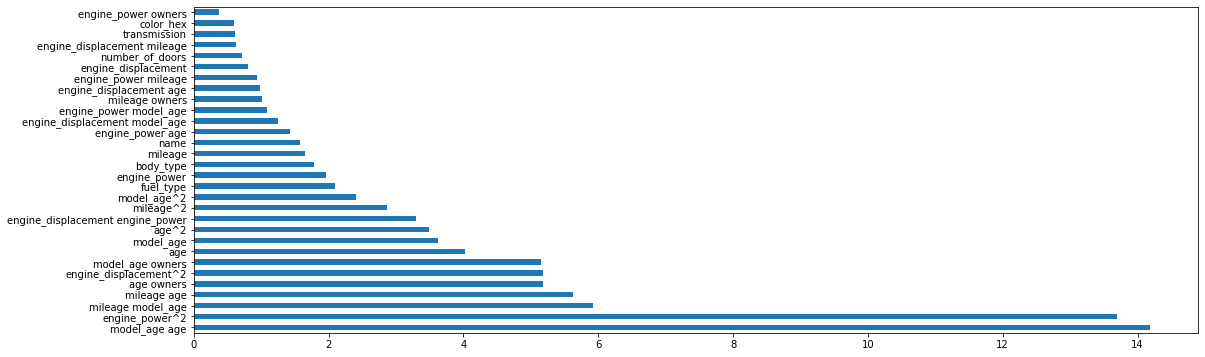

In [51]:
feat_importances = pd.Series(model.feature_importances_, index=set_5)
plt.figure(figsize=(18,6))
feat_importances.nlargest(30).plot(kind='barh');

Лучший из (более чем пяти, приведены базовые варианты) результатов оказался базовым набором фич с добавленными полиномиальными, которые доминируют в рейтинге значимости. Стоит отметить, что метрика сабмита по сравнению с базовым вариантом была улучшена незначительно. Сокращение количества признаков до топа значимых (с довеском или без) точность не повышало. (Это касается и базовго сета, в частности)

In [52]:
submit_y = model.predict(test[set_5])
submit_y = np.exp(submit_y/10000)
submit_y # для проверки порядка значений 

array([1906162.12806915, 2691721.09985956, 1454625.32773661, ...,
        494475.17759839, 1132687.98813828, 1200687.92828055])

In [53]:
sample_submission = pd.DataFrame()
sample_submission['id']=sample_submission.index

In [54]:
X=train[set_5]
y=train.price_log
X_sub = test[set_5]

In [55]:

VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1


ITERATIONS = 2000
LR         = 0.1 # Параметры из hyperopt
CSBL       = 0.6 # Но лучше без них
MD         = 5


                        


def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              #colsample_bylevel = CSBL, 
                              #max_depth = MD,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
    model.fit(X_train, y_train,
              cat_features=cat_cols,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)



submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.5f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_sub)
    #model.save_model(f'catboost_fold_{idx+1}.model')

print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold Test MAPE: 0.00905
2 Fold Test MAPE: 0.00913
3 Fold Test MAPE: 0.00978
4 Fold Test MAPE: 0.00951
5 Fold Test MAPE: 0.00938

Mean Score: 0.009
Std Score: 0.0003
Max Score: 0.010
Min Score: 0.009


Как оказалось, разница в датировке сетов привела существенной поправке на курс/инфляцию, которую пришлось устанавливать подбором. 

In [56]:
RATE = 0.91
sample_submission = pd.DataFrame()
submissions['blend'] = submissions.mean(axis=1)


sample_submission['id']=test['id']
sample_submission['price'] = np.exp(submissions['blend']/10000)*RATE
sample_submission.to_csv('another_one.csv', index=False)